## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is critical to get experience working with this type of analysis.

For this project, i will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the __new page__, keep the __old page__, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Start witht some data cheking

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Display the fist 5 rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Number of rows and columns respectively in the ab_data dataset
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
# number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now let's use the answer to the quiz to create a new dataset that meets the specifications. And let's store our new dataframe as **df2**.

In [9]:
# Make the df2 in use For the rows where treatment is not aligned with new_page or control is not aligned with old_page
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions below.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates()

In [15]:
sum(df2.duplicated())

0

`4.` Use **df2** in the below cells to answer questions related to **Quiz 4**.

a. What is the probability of an individual converting regardless of the page they receive?

In [89]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_group = len(df2.query('group == "control" and converted == 1'))/len(df2.query('group == "control"'))

control_group

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treat_group = len(df2.query('group == "treatment" and converted == 1'))/len(df2.query('group == "treatment"'))

treat_group

0.11880724790277405

d. What is the probability that an individual received the new page?

In [18]:
len(df2.query('landing_page == "new_page"'))/len(df2.index)

0.5000636646764286

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The probability of an induvidual converting regardless of the page they are in is 0.1196, for an individual coverting in control group is 0.1204 and for an induividual converting in treatment group is 0.1188. By observing the conversion rate which is 0.0015 (almost to 0) and the probability that an individual received the new_page which is 0.5, we can conclude that there is no difference between old and new landing page in conversion. Thus, since the conversion rate is almost equal to zero (0), we should think about considering other facts.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, let's consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**H0: There is no statistically significant difference between sample distribution and theoretical normal distribution**

**H1: There is statistically significant difference between sample distribution and theoretical normal distribution.**

**The test rejects the null hypotesis when the p-value is less than or equal to 0.5. Failing to reject the null hypothesis will allow us to state that we are 95% confident that the data does not fit the normal distribution.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = len(df2.query('converted == 1'))/len(df2.index)
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = len(df2.query('converted == 1'))/len(df2.index)
p_old

0.11959667567149027

In [21]:
# Probability under the null
p = np.mean([p_old,p_new])
print(p)

# get the p_diff
p_diff = p_new - p_old

0.11959667567149027


c. What is $n_{new}$?

In [22]:
# number of queries where landing page is new_page
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145311

d. What is $n_{old}$?

In [23]:
# number of queries where landing page is old_page
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
## simulate n_new transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# simulate n_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# Difference of new converted page and old converted page in mean
obs_diff = new_page_converted.mean() - old_page_converted.mean()

obs_diff

-0.0007951877497265336

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# create sampling distribution for the for the difference in p_new and p_old for the mean
p_diffs = []
for i in range(10000):
    
    p_new = np.random.choice([1, 0],n_new)
    p_old = np.random.choice([1, 0],n_old)
    p_new_mean = p_new.mean()
    p_old_mean = p_old.mean()
    p_diffs.append(p_new_mean-p_old_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'Count')

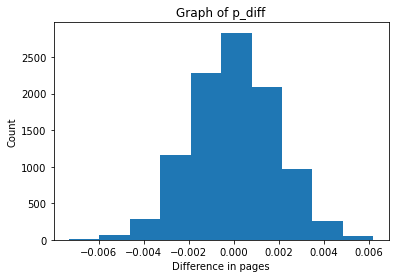

In [28]:
p_diffs = np.array(p_diffs)

# Plot p_diffs in a histogram
plt.hist(p_diffs)
plt.title("Graph of p_diff")
plt.xlabel("Difference in pages")
plt.ylabel("Count")

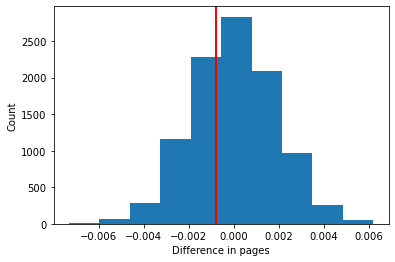

In [29]:
#Let's include the actuall obseved difference to check where the line lands in the histogram
plt.hist(p_diffs)
plt.xlabel("Difference in pages")
plt.ylabel("Count")

plt.axvline(x = obs_diff, color = 'r', linewidth = 2)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
conv_new_page_mean = (df2[df2['landing_page'] == "new_page"])['converted'].mean()
conv_old_page_mean = (df2[df2['landing_page'] == "old_page"])['converted'].mean()
obs_diff = conv_new_page_mean - conv_old_page_mean
count = 0

for i in p_diffs:
    if i > obs_diff:
        count += 1
        
count/(len(p_diffs))

0.8018

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**What i just got from the part 'j' is th p-value. This means that we are 80% confident that the new page does not give better results than the old page. Therefore, we should not reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

# number of rows converted in old page
convert_old = len(df2.query('converted == 1 and landing_page == "old_page"'))
# number of rows converted in  new page
convert_new = len(df2.query('converted == 1 and landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"')) # rows in old page
n_new = len(df2.query('landing_page == "new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3116075339133115, 0.905173705140591)

In [34]:
# showing how significant our z_score is
from scipy.stats import norm
norm.cdf(z_score)

0.905173705140591

In [35]:
# Checking criticat value of 95% confidence
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z_score is less than the 95% confidence. Thus, we fail to reject the null hypotesis. Therefore, the conclusion is the same as the part j, we don't reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since there are only two options, i will be performing the 'Logistic Regression'.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] = 1

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
page_log = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = page_log.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
print(results.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2022-10-08 20:49 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074



e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer**

In logistic regression, the null and altergative hypotheses are presented as follow:

- __H0: p_new - p_old = 0__
- __H1: p_new - p_old != 0__

Whereas, in part II, there were presented:
- __H0: p_new - p_old >= 0__
- __H1: p_new - p_old < 0__

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Additional factors should be added into the regression model and there are othothings that might influence an individual to convert. The disadvantege is that we don't know in which way these factors will influent the results.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [44]:
### Create the necessary dummy variables
df_new[['US', 'UK']] = pd.get_dummies(df_new['country'])[['US', 'UK']]

#display the first 5 rows from proof
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0


In [45]:
# Combine US with the ab_page column
df_new['US_ab_page'] = df_new['ab_page']*df_new['US']

# display the first 5 rows for proof
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1


In [46]:
# Combine UK with the ab_page column
df_new['UK_ab_page'] = df_new['ab_page']*df_new['UK']

# display the first 5 rows for proof
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1,0


In [47]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
logi_page = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])
results = logi_page.fit()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


When we fit the logistic regrassion, we can see that the number of iteration to be 6 with the current function value of almost 0.37. Therefore, the country does not have an impact on conversion

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
# Get the summary of the results
print(results.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9124
Date:               2022-10-08 20:56 BIC:              212846.3903
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.19182    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             

In [51]:
# veislize the coefficient for the ab_page, US, UK, US_ab_page, UK_ab_page
1/np.exp(-0.0674), np.exp(0.0175), np.exp(0.0118), np.exp(0.0469), np.exp(0.0783)

(1.0697232819209153,
 1.0176540221507617,
 1.011869894648401,
 1.048017202119183,
 1.0814470441230692)

## Regression analysis conclusion
- For each 1 unit decrease in new_page, convert is 1.5 times as likely holding all other values constants.
- For each 1 unit increase in US, covert is 1.8 times as likely holding all other values constants.
- For each 1 unit increase in UK, convert is 1.2 times as likely holding all other values constants.
- For each 1 unit increase in US new page, convert is 4.8 times as likely holding all other values constants.
- For each 1 unit increase in UK new page, convert is 8.1 times as likely holding all other values constants

<a id='conclusions'></a>
## Conclusions

**The analyis was based on the data about a website, the purpose was to analyse the data statistically to decide if the company should adapt with the new page or should stick to the old one based on the conversion of two groups (the treatment group - which is with the new page and the control group - which is witht the old group.**

**To reach at this goal, we performed the A/B test with z-test and logistic regression models. In A/B test, we found the p-value is higher than type error I, and therefore, we fail to reject the null hyphotesis. With the z-score, it was 1.31 which does not exceed the critical value of 1.64, so we fail again to reject the null hyphothesis.**


And the coeffient for our regressionanalysis concludes the following: For each 1 unit decrease in new_page, convert is 1.5 times as likely holding all other values constants. For each 1 unit increase in US, covert is 1.8 times as likely holding all other values constants. For each 1 unit increase in UK, convert is 1.2 times as likely holding all other values constants. For each 1 unit increase in US new page, convert is 4.8 times as likely holding all other values constants. For each 1 unit increase in UK new page, convert is 8.1 times as likely holding all other values constants.

Based on the data we have on a time of 22 days, we find it insuficient to decide if we could keep the old page or start unsing the new one even though the all the test showed that we should keep the old page.